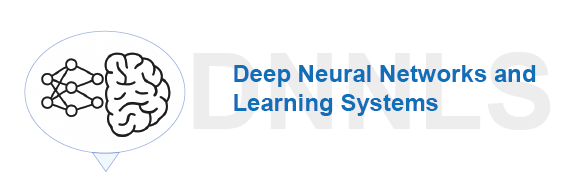

# Final assessment - Main Notebook
---

**Introduction:**

In this notebook you will find a baseline, functional architecture for your assessment task.

In [1]:
!pip install transformers datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import os
import gc
import re
import textwrap

from bs4 import BeautifulSoup

import torchvision.transforms as transforms
import torchvision.transforms.functional as FT

from torch.utils.data import Dataset, DataLoader, Subset
from transformers import BertTokenizer
from datasets import load_dataset

from google.colab import drive

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


# **Chapter 1: The data preparation**


---



First we need to activate our google drive so that we can save out data permanently.

## 1.1 Loading and saving data

In [3]:
# @title Setting up google drive to save checkpoints
drive.mount('/content/gdrive')

def save_checkpoint_to_drive(model, optimizer, epoch, loss, filename="autoencoder_checkpoint.pth"):
    """
    Saves the checkpoint directly to a specified folder in your mounted Google Drive.
    """
    # 1. Define the full Google Drive path
    # 'DL_Checkpoints' is the folder you want to save to inside your Drive
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'

    # Ensure the directory exists before attempting to save
    os.makedirs(drive_folder, exist_ok=True)

    # 2. Combine the folder and the filename
    full_path = os.path.join(drive_folder, filename)

    # 3. Create the checkpoint dictionary
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }

    # 4. Save the dictionary to the Google Drive path
    torch.save(checkpoint, full_path)
    print(f"Checkpoint saved to Google Drive: {full_path} at epoch {epoch}")


def load_checkpoint_from_drive(model, optimizer=None, filename="autoencoder_checkpoint.pth"):
    """
    Loads a checkpoint from your Google Drive folder into the model and optimizer (if provided).
    """
    # Define the same Google Drive folder path
    drive_folder = '/content/gdrive/MyDrive/DL_Checkpoints'
    full_path = os.path.join(drive_folder, filename)

    # Check if the checkpoint file exists
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"Checkpoint file not found: {full_path}")

    # Load the checkpoint
    checkpoint = torch.load(full_path, map_location=torch.device('cpu'))  # use cuda if available

    # Restore model state
    model.load_state_dict(checkpoint['model_state_dict'])

    # Restore optimizer state (if provided)
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Extract metadata
    epoch = checkpoint.get('epoch', 0)
    loss = checkpoint.get('loss', None)

    print(f"Checkpoint loaded from: {full_path} (epoch {epoch})")

    return model, optimizer, epoch, loss



Mounted at /content/gdrive


We need to define a couple of functions to make our life easier. Feel free to tweak those functions:

In [4]:
def parse_gdi_text(text):
    """Parse GDI formatted text into structured data."""
    soup = BeautifulSoup(text, "html.parser")
    images = []

    for gdi in soup.find_all("gdi"):
        image_id = None
        if gdi.attrs:
            for attr_name in gdi.attrs:
                if "image" in attr_name.lower():
                    image_id = attr_name.replace("image", "")
                    break

        # Regex fallback
        if not image_id:
            tag_str = str(gdi)
            match = re.search(r"<gdi\s+image(\d+)", tag_str)
            if match:
                image_id = match.group(1)

        # Final fallback
        if not image_id:
            image_id = str(len(images) + 1)

        content = gdi.get_text().strip()

        objects = [obj.get_text().strip() for obj in gdi.find_all("gdo")]
        actions = [act.get_text().strip() for act in gdi.find_all("gda")]
        locations = [loc.get_text().strip() for loc in gdi.find_all("gdl")]

        images.append({
            "image_id": image_id,
            "description": content,
            "objects": objects,
            "actions": actions,
            "locations": locations,
            "raw_text": str(gdi)
        })

    return images


def show_image(ax, image):
    """
    image: torch tensor (C,H,W) in [0,1]
    """
    ax.imshow(image.permute(1, 2, 0))
    ax.axis("off")


Now we load dataset from HuggingFace:

In [5]:
train_dataset = load_dataset("daniel3303/StoryReasoning", split="train")
test_dataset  = load_dataset("daniel3303/StoryReasoning", split="test")

print("Train size:", len(train_dataset))
print("Test size :", len(test_dataset))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/327M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/331M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/115M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3552 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/626 [00:00<?, ? examples/s]

Train size: 3552
Test size : 626


In a previous lab, we analyzed the statistics of the images and figure out that a size of 240x500 could be good enough to standarize, but we will use 60x125. Also, we will restrict ourselves to taking only 5 frames from all the sequences.


## 1.2 Three datasets


---



We will create three different dataset objects and the corresponding loaders for performing multiple tasks

In [6]:
# Tokenizer + transforms

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
PAD_ID = tokenizer.pad_token_id
print("PAD_ID:", PAD_ID)

import torchvision.transforms as T
clean_transform = T.Compose([
    T.Resize((60, 125)),
    T.ToTensor()
])

# LIGHT augmentation, small domain shift, minimal blur
light_transform = T.Compose([
    T.Resize((60, 125)),
    T.RandomApply([T.ColorJitter(brightness=0.20, contrast=0.20)], p=0.30),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.03, 0.03))], p=0.20),
    T.ToTensor(),
    T.Lambda(lambda x: torch.clamp(x, 0.0, 1.0))
])

# FULL augmentation
full_transform = T.Compose([
    T.Resize((60, 125)),
    T.RandomApply([T.GaussianBlur(kernel_size=3)], p=0.25),
    T.RandomApply([T.ColorJitter(brightness=0.25, contrast=0.25)], p=0.35),
    T.RandomApply([T.RandomAffine(degrees=0, translate=(0.05, 0.05))], p=0.25),
    T.ToTensor(),
    T.Lambda(lambda x: x + 0.03 * torch.randn_like(x) if torch.rand(1).item() < 0.25 else x),
    T.Lambda(lambda x: torch.clamp(x, 0.0, 1.0))
])

# For val/test always clean
eval_transform = clean_transform


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

PAD_ID: 0


In [7]:
# SequencePredictionDataset

class SequencePredictionDataset(Dataset):
    def __init__(self, original_dataset, tokenizer, mode="clean", max_len=120):
        """
        mode: "clean" | "light" | "train" | "val" | "test"
        """
        super().__init__()
        self.dataset = original_dataset
        self.tokenizer = tokenizer
        self.mode = mode
        self.max_len = max_len

    def set_mode(self, mode):
        self.mode = mode

    def _apply_transform(self, img):
        if self.mode == "clean":
            return clean_transform(img)
        elif self.mode == "light":
            return light_transform(img)
        elif self.mode == "train":
            return full_transform(img)
        else:  # val / test
            return eval_transform(img)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        frames = item["images"]
        attrs = parse_gdi_text(item["story"])

        frame_tensors = []
        desc_ids_list = []

        # First 4 frames
        for i in range(4):
            img = FT.equalize(frames[i])
            img = self._apply_transform(img)
            frame_tensors.append(img)

            desc = attrs[i]["description"]
            ids = self.tokenizer(
                desc,
                return_tensors="pt",
                padding="max_length",
                truncation=True,
                max_length=self.max_len
            ).input_ids.squeeze(0)
            desc_ids_list.append(ids)

        # Target frame + text
        target_img = FT.equalize(frames[4])
        target_img = self._apply_transform(target_img)

        text_target = attrs[4]["description"]
        target_ids = self.tokenizer(
            text_target,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=self.max_len
        ).input_ids  # (1, T)

        return (
            torch.stack(frame_tensors),      # (4, C, H, W)
            torch.stack(desc_ids_list),      # (4, T)
            target_img,                      # (C, H, W)
            target_ids                       # (1, T)
        )


We will use text autoencoding (reconstructing the same text) to develop representations of the text (I provide some existing weights for this, but you can train your own)

In [8]:
# TextTaskDataset (text autoencoding)
class TextTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        attrs = parse_gdi_text(self.dataset[idx]["story"])
        frame_idx = np.random.randint(0, 5)
        return attrs[frame_idx]["description"]


And also a dataset for a potential image autoencoder task if you want to develop some visual features before training the whose archicture.

In [9]:
#AutoEncoderTaskDataset (visual autoencoder)

class AutoEncoderTaskDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = T.Compose([
            T.Resize((60, 125)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        frames = self.dataset[idx]["images"]
        frame_idx = torch.randint(0, len(frames), (1,)).item()
        return self.transform(frames[frame_idx])


Train size: 2841 | Val size: 711 | Test size: 626
Frames shape: torch.Size([8, 4, 3, 60, 125])
Descriptions shape: torch.Size([8, 4, 120])
Image target shape: torch.Size([8, 3, 60, 125])
Text target shape: torch.Size([8, 1, 120])


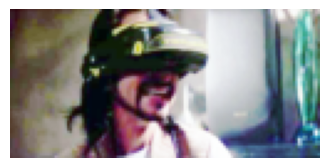

In [10]:
from torch.utils.data import Subset, DataLoader

train_dataset_obj = SequencePredictionDataset(train_dataset, tokenizer, mode="train")
val_dataset_obj   = SequencePredictionDataset(train_dataset, tokenizer, mode="val")
test_dataset_obj  = SequencePredictionDataset(test_dataset,  tokenizer, mode="test")
num_total = len(train_dataset)
perm = torch.randperm(num_total).tolist()

train_size = int(0.80 * num_total)
train_indices = perm[:train_size]
val_indices   = perm[train_size:]

train_subset = Subset(train_dataset_obj, train_indices)
val_subset   = Subset(val_dataset_obj, val_indices)

print(f"Train size: {len(train_subset)} | Val size: {len(val_subset)} | Test size: {len(test_dataset_obj)}")

#DataLoaders
train_dataloader = DataLoader(
    train_subset,
    batch_size=8,
    shuffle=True,
    num_workers=0
)

val_dataloader = DataLoader(
    val_subset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

test_dataloader = DataLoader(
    test_dataset_obj,
    batch_size=4,
    shuffle=False,
    num_workers=0
)


#Sanity check
frames, descriptions, image_target, text_target = next(iter(train_dataloader))

print("Frames shape:", frames.shape)
print("Descriptions shape:", descriptions.shape)
print("Image target shape:", image_target.shape)
print("Text target shape:", text_target.shape)

# show one target image
fig, ax = plt.subplots(1, 1, figsize=(4, 2))
show_image(ax, image_target[0].cpu())
plt.show()


In [11]:
#Text autoencoder
class EncoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

    def forward(self, input_ids):
        # input_ids: (B, T)
        x = self.embedding(input_ids)
        outputs, (h, c) = self.lstm(x)
        return outputs, h, c

class DecoderLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM for sequence generation
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )

        # Projects hidden states → vocabulary logits
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, input_ids, h, c):
        # input_ids: (B, T-1)
        x = self.embedding(input_ids)           # (B, T-1, E)
        outputs, (h, c) = self.lstm(x, (h, c))  # (B, T-1, H)
        logits = self.out(outputs)              # (B, T-1, vocab_size)
        return logits, h, c


#combining encoder + decoder
class Seq2SeqLSTM(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_ids, target_ids):
        """
        input_ids:  (B, T)  → text from previous frames
        target_ids: (B, T)  → ground-truth text to reconstruct
        """

        # Encode the input text sequence
        _, h, c = self.encoder(input_ids)

        # Teacher forcing:
        # feed target tokens except the last one
        decoder_input = target_ids[:, :-1]      # (B, T-1)

        # Decoder predicts the next token at each step
        logits, _, _ = self.decoder(decoder_input, h, c)

        # logits: (B, T-1, vocab_size)
        return logits
# Instantiate the model
emb_dim = 128
text_hidden_dim = 256
num_layers = 1
dropout = 0.1
# Build encoder and decoder
text_encoder = EncoderLSTM(
    tokenizer.vocab_size, emb_dim, text_hidden_dim, num_layers, dropout
).to(device)

text_decoder = DecoderLSTM(
    tokenizer.vocab_size, emb_dim, text_hidden_dim, num_layers, dropout
).to(device)

# Wrap them into a Seq2Seq model
text_autoencoder = Seq2SeqLSTM(text_encoder, text_decoder).to(device)

# Load pretrained weights
try:
    text_autoencoder, _, _, _ = load_checkpoint_from_drive(
        text_autoencoder,
        optimizer=None,
        filename="text_autoencoder.pth"
    )
    print("Loaded pretrained text autoencoder from Drive.")
except FileNotFoundError:
    print("No pretrained text autoencoder found — training from scratch.")

# Freeze text autoencoder
# We freeze it initially so:
#text learning stays stable
#image prediction can converge first
#avoids exploding gradients in multimodal training

FREEZE_TEXT_AUTOENCODER = True

if FREEZE_TEXT_AUTOENCODER:
    for param in text_autoencoder.parameters():
        param.requires_grad = False
    print("Text autoencoder is FROZEN.")
else:
    print("Text autoencoder is TRAINABLE.")


No pretrained text autoencoder found — training from scratch.
Text autoencoder is FROZEN.


In [12]:
#VISUAL AUTOENCODER
class VisualEncoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()

        # CNN encoder: (3,60,125) -> (64,8,16)
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=7, stride=2, padding=3),   # -> (16,30,63)
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),

            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2),  # -> (32,15,32)
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # -> (64,8,16)
            nn.GroupNorm(8, 64),
            nn.LeakyReLU(0.1),
        )
        self.feature_shape = (64, 8, 16)
        self.flatten_dim = 64 * 8 * 16
        self.fc = nn.Sequential(
            nn.Linear(self.flatten_dim, latent_dim),
            nn.ReLU()
        )

    def forward(self, x):
        # x: (B,3,60,125)
        x = self.encoder_conv(x)           # (B,64,8,16)
        x = x.view(x.size(0), -1)          # (B,8192)
        z = self.fc(x)                     # (B,latent_dim)
        return z
class VisualDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.imh = 60
        self.imw = 125
        self.initial_shape = (64, 8, 16)
        self.flatten_dim = 64 * 8 * 16
        self.fc = nn.Linear(latent_dim, self.flatten_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (32,16,32)
            nn.GroupNorm(8, 32),
            nn.LeakyReLU(0.1),nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1),  # -> (16,32,64)
            nn.GroupNorm(8, 16),
            nn.LeakyReLU(0.1),
            nn.ConvTranspose2d(16, 3, kernel_size=7, stride=2, padding=3, output_padding=1),   # -> (3,64,128)
            nn.Sigmoid()  # keep in [0,1]
        )

    def forward(self, z):
        # z: (B, latent_dim)
        x = self.fc(z)                                       # (B,8192)
        x = x.view(-1, *self.initial_shape)                  # (B,64,8,16)
        x = self.decoder_conv(x)                             # (B,3,~64,~128)
        x = x[:, :, :self.imh, :self.imw]                    # crop -> (B,3,60,125)
        return x


class VisualAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.encoder = VisualEncoder(latent_dim)
        self.decoder = VisualDecoder(latent_dim)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

visual_latent_dim = 128
visual_autoencoder = VisualAutoencoder(latent_dim=visual_latent_dim).to(device)
dummy = torch.randn(2, 3, 60, 125).to(device)
out = visual_autoencoder(dummy)
print("Visual AE output shape:", out.shape)


Visual AE output shape: torch.Size([2, 3, 60, 125])


[AE] Epoch 1/10  Loss: 0.1218
[AE] Epoch 2/10  Loss: 0.0860
[AE] Epoch 3/10  Loss: 0.0791
[AE] Epoch 4/10  Loss: 0.0745
[AE] Epoch 5/10  Loss: 0.0717
[AE] Epoch 6/10  Loss: 0.0707
[AE] Epoch 7/10  Loss: 0.0698
[AE] Epoch 8/10  Loss: 0.0688
[AE] Epoch 9/10  Loss: 0.0674
[AE] Epoch 10/10  Loss: 0.0676
Checkpoint saved to Google Drive: /content/gdrive/MyDrive/DL_Checkpoints/visual_autoencoder_pretrained.pth at epoch 10


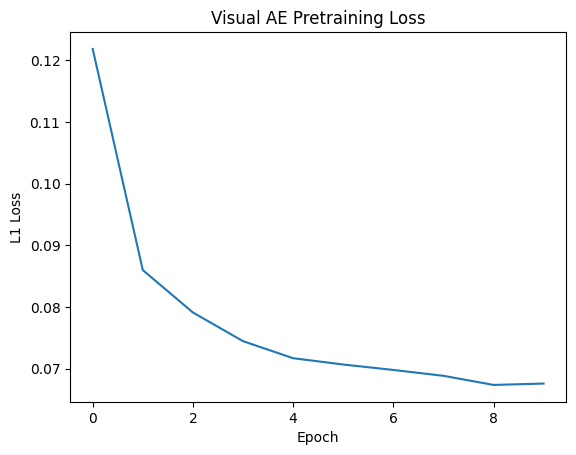

In [13]:
#VISUAL AE PRETRAIN
autoencoder_dataset = AutoEncoderTaskDataset(train_dataset)
autoencoder_dataloader = DataLoader(autoencoder_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

# Loss + optimizer
criterion_ae = nn.L1Loss()
optimizer_ae = torch.optim.Adam(visual_autoencoder.parameters(), lr=1e-3)

AE_EPOCHS = 10
visual_autoencoder.train()
ae_losses = []

for epoch in range(AE_EPOCHS):
    running = 0.0

    for imgs in autoencoder_dataloader:
        imgs = imgs.to(device)

        optimizer_ae.zero_grad()
        recon = visual_autoencoder(imgs)
        loss = criterion_ae(recon, imgs)
        loss.backward()
        optimizer_ae.step()

        running += loss.item() * imgs.size(0)

    epoch_loss = running / len(autoencoder_dataloader.dataset)
    ae_losses.append(epoch_loss)
    print(f"[AE] Epoch {epoch+1}/{AE_EPOCHS}  Loss: {epoch_loss:.4f}")

# Save AE checkpoint
save_checkpoint_to_drive(
    visual_autoencoder,
    optimizer_ae,
    AE_EPOCHS,
    ae_losses[-1],
    filename="visual_autoencoder_pretrained.pth"
)

# Plot AE loss
plt.figure()
plt.plot(ae_losses)
plt.title("Visual AE Pretraining Loss")
plt.xlabel("Epoch")
plt.ylabel("L1 Loss")
plt.show()


In [14]:
#SEQUENCE PREDICTOR
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim, 1)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, rnn_outputs):
        # rnn_outputs: (B, S, H)
        energy = self.attn(rnn_outputs).squeeze(2)        # (B, S)
        weights = self.softmax(energy)                    # (B, S)
        context = torch.bmm(weights.unsqueeze(1), rnn_outputs)  # (B,1,H)
        return context.squeeze(1)                         # (B, H)

class SequencePredictor(nn.Module):
    def __init__(self, visual_autoencoder, text_autoencoder,
                 visual_latent_dim, text_hidden_dim, gru_hidden_dim):
        super().__init__()

        # Encoders
        self.image_encoder = visual_autoencoder.encoder
        self.text_encoder  = text_autoencoder.encoder

        # Temporal model (fuse image+text per frame)
        fusion_dim = visual_latent_dim + text_hidden_dim
        self.temporal_rnn = nn.GRU(fusion_dim, gru_hidden_dim, batch_first=True)
        self.attention = Attention(gru_hidden_dim)
        self.projection = nn.Sequential(
            nn.Linear(gru_hidden_dim * 2, visual_latent_dim),
            nn.ReLU()
        )

        # Decoders
        self.image_decoder = visual_autoencoder.decoder
        self.text_decoder  = text_autoencoder.decoder
        self.fused_to_h0 = nn.Linear(visual_latent_dim, text_hidden_dim)
        self.fused_to_c0 = nn.Linear(visual_latent_dim, text_hidden_dim)

    def forward(self, image_seq, text_seq, target_seq):
        """
        image_seq: (B, 4, 3, 60, 125)
        text_seq:  (B, 4, 120)
        target_seq: (B, 1, 120)
        returns:
          pred_image: (B, 3, 60, 125)
          pred_text_logits: (B, 119, vocab)
          h0, c0: (1, B, text_hidden_dim)
        """
        B, S, C, H, W = image_seq.shape

        #image encode each frame
        img_flat = image_seq.view(B * S, C, H, W)
        z_v = self.image_encoder(img_flat)
        z_v = z_v.view(B, S, -1)

        #text encode each frame
        txt_flat = text_seq.view(B * S, -1)
        _, h, c = self.text_encoder(txt_flat)
        z_t = h.squeeze(0).view(B, S, -1)
        z_fuse = torch.cat([z_v, z_t], dim=-1)

        #temporal GRU
        zseq, h_last = self.temporal_rnn(z_fuse)
        h_last = h_last.squeeze(0)

        # ---- attention ----
        ctx = self.attention(zseq)

        # ---- project to visual latent ----
        z = self.projection(torch.cat([h_last, ctx], dim=-1))

        # ---- decode image ----
        pred_image = self.image_decoder(z)

        # ---- init text decoder ----
        h0 = self.fused_to_h0(z).unsqueeze(0)
        c0 = self.fused_to_c0(z).unsqueeze(0)

        #feed target[:-1], predict target[1:]
        decoder_in = target_seq[:, 0, :-1]
        pred_text_logits, _, _ = self.text_decoder(decoder_in, h0, c0)

        return pred_image, pred_text_logits, h0, c0


#instantiate predictor
gru_hidden_dim = 256  # stable
sequence_predictor = SequencePredictor(
    visual_autoencoder=visual_autoencoder,
    text_autoencoder=text_autoencoder,
    visual_latent_dim=visual_latent_dim,
    text_hidden_dim=text_hidden_dim,
    gru_hidden_dim=gru_hidden_dim
).to(device)

trainable_params = sum(p.numel() for p in sequence_predictor.parameters() if p.requires_grad)
print("Trainable params (sequence_predictor):", trainable_params)


Trainable params (sequence_predictor): 2798148


In [15]:
#unfreeze decoder + add adapter
for p in text_autoencoder.encoder.parameters():
    p.requires_grad = False

for p in text_autoencoder.decoder.parameters():
    p.requires_grad = True

print("Text encoder frozen:", all(not p.requires_grad for p in text_autoencoder.encoder.parameters()))
print("Text decoder trainable:", any(p.requires_grad for p in text_autoencoder.decoder.parameters()))

#Added an adapter inside the sequence predictor for better conditioning
sequence_predictor.fused_adapter = nn.Sequential(
    nn.Linear(visual_latent_dim, visual_latent_dim),
    nn.ReLU(),
    nn.Linear(visual_latent_dim, visual_latent_dim)
).to(device)

sequence_predictor.fused_to_h0 = nn.Linear(visual_latent_dim, text_hidden_dim).to(device)
sequence_predictor.fused_to_c0 = nn.Linear(visual_latent_dim, text_hidden_dim).to(device)

print("Adapter added. Conditioning will be stronger.")


Text encoder frozen: True
Text decoder trainable: True
Adapter added. Conditioning will be stronger.


In [16]:
#VALIDATION VIS

def generate_text(decoder, h0, c0, max_len=80):
    """
    Simple autoregressive generation from DecoderLSTM using initial hidden states.
    """
    decoder.eval()

    # start token ([CLS])
    dec_input = torch.tensor([[tokenizer.cls_token_id]], device=device)

    generated = []

    for _ in range(max_len):
        with torch.no_grad():
            logits, h0, c0 = decoder(dec_input, h0, c0)

        next_id = torch.argmax(logits[:, -1, :], dim=-1).item()

        if next_id == tokenizer.sep_token_id:
            break
        if next_id == tokenizer.cls_token_id or next_id == tokenizer.pad_token_id:
            dec_input = torch.tensor([[next_id]], device=device)
            continue

        generated.append(next_id)
        dec_input = torch.tensor([[next_id]], device=device)

    return tokenizer.decode(generated, skip_special_tokens=True)


def validation(model, data_loader):
    model.eval()
    with torch.no_grad():
        frames, descriptions, image_target, text_target = next(iter(data_loader))

        frames = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target = text_target.to(device)

        # forward
        pred_image, pred_text_logits, h0, c0 = model(frames, descriptions, text_target)

        fig, ax = plt.subplots(2, 6, figsize=(20, 5), gridspec_kw={"height_ratios": [2, 1.5]})

        # show 4 input frames + their texts
        for i in range(4):
            show_image(ax[0, i], frames[0, i].cpu())
            ax[0, i].set_title(f"Input {i+1}")

            txt = tokenizer.decode(descriptions[0, i], skip_special_tokens=True)
            ax[1, i].text(0.5, 0.95, textwrap.fill(txt, 40), ha="center", va="top")
            ax[1, i].axis("off")

        # target image + target text
        show_image(ax[0, 4], image_target[0].cpu())
        ax[0, 4].set_title("Target")

        tgt_txt = tokenizer.decode(text_target[0, 0], skip_special_tokens=True)
        ax[1, 4].text(0.5, 0.95, textwrap.fill(tgt_txt, 40), ha="center", va="top")
        ax[1, 4].axis("off")

        # predicted image + generated text
        show_image(ax[0, 5], pred_image[0].cpu())
        ax[0, 5].set_title("Predicted")

        # generate text using the decoder + (h0,c0) for sample 0
        gen = generate_text(model.text_decoder, h0[:, 0:1, :], c0[:, 0:1, :], max_len=80)
        ax[1, 5].text(0.5, 0.95, textwrap.fill(gen, 40), ha="center", va="top")
        ax[1, 5].axis("off")

        plt.tight_layout()
        plt.show()


In [17]:
# FIX A2: Rebuild optimizer to include newly trainable params

trainable_params = [p for p in sequence_predictor.parameters() if p.requires_grad]
trainable_params += [p for p in text_autoencoder.decoder.parameters() if p.requires_grad]

optimizer = torch.optim.Adam(trainable_params, lr=5e-4)
print("Optimizer rebuilt. Trainable param count:", sum(p.numel() for p in trainable_params))


Optimizer rebuilt. Trainable param count: 27123640


/usr/local/lib/python3.12/dist-packages/torch/_compile.py:53: UserWarning: optimizer contains a parameter group with duplicate parameters; in future, this will cause an error; see github.com/pytorch/pytorch/issues/40967 for more information
  return disable_fn(*args, **kwargs)


In [18]:
# =========================
# CELL 14: TRAINING LOOP
# =========================

def edge_loss(pred, target):
    # Simple Sobel filter for edge detection
    sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32, device=pred.device).reshape(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32, device=pred.device).reshape(1, 1, 3, 3)

    # Expand sobel filters to match image channels
    sobel_x = sobel_x.repeat(pred.shape[1], 1, 1, 1)
    sobel_y = sobel_y.repeat(pred.shape[1], 1, 1, 1)

    # Apply convolution to each channel
    edges_pred_x = F.conv2d(pred, sobel_x, padding=1, groups=pred.shape[1])
    edges_pred_y = F.conv2d(pred, sobel_y, padding=1, groups=pred.shape[1])
    edges_target_x = F.conv2d(target, sobel_x, padding=1, groups=target.shape[1])
    edges_target_y = F.conv2d(target, sobel_y, padding=1, groups=target.shape[1])

    # Calculate magnitude of gradients
    edges_pred = torch.sqrt(edges_pred_x**2 + edges_pred_y**2)
    edges_target = torch.sqrt(edges_target_x**2 + edges_target_y**2)

    # L1 loss on edges
    return F.l1_loss(edges_pred, edges_target)

criterion_images = nn.L1Loss()
criterion_text = nn.CrossEntropyLoss(ignore_index=PAD_ID)

optimizer = torch.optim.Adam(
    [p for p in sequence_predictor.parameters() if p.requires_grad],
    lr=1e-3
)

N_EPOCHS = 10
losses_train = []
losses_val = []

for epoch in range(N_EPOCHS):
    sequence_predictor.train()
    running = 0.0

    for frames, descriptions, image_target, text_target in train_dataloader:
        frames = frames.to(device)
        descriptions = descriptions.to(device)
        image_target = image_target.to(device)
        text_target = text_target.to(device)            # (B,1,120)

        # forward
        pred_image, pred_text_logits, _, _ = sequence_predictor(frames, descriptions, text_target)
        # pred_text_logits: (B,119,V)

        # --- image loss ---
        loss_im = criterion_images(pred_image, image_target)

        # --- text loss (this is the correct alignment) ---
        targets = text_target[:, 0, 1:]                 # (B,119) = target tokens excluding first token
        logits  = pred_text_logits.reshape(-1, tokenizer.vocab_size)  # (B*119, V)
        labels  = targets.reshape(-1)                   # (B*119)

        loss_txt = criterion_text(logits, labels)

        loss_edge = edge_loss(pred_image, image_target)
        loss = loss_im + 0.5 * loss_edge + loss_txt


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running += loss.item() * frames.size(0)

    train_loss = running / len(train_dataloader.dataset)
    losses_train.append(train_loss)

    # --- quick validation loss (no gradients) ---
    sequence_predictor.eval()
    val_running = 0.0
    with torch.no_grad():
        for frames, descriptions, image_target, text_target in val_dataloader:
            frames = frames.to(device)
            descriptions = descriptions.to(device)
            image_target = image_target.to(device)
            text_target = text_target.to(device)

            pred_image, pred_text_logits, _, _ = sequence_predictor(frames, descriptions, text_target)

            loss_im = criterion_images(pred_image, image_target)
            targets = text_target[:, 0, 1:]
            logits  = pred_text_logits.reshape(-1, tokenizer.vocab_size)
            labels  = targets.reshape(-1)
            loss_txt = criterion_text(logits, labels)

            loss = loss_im + loss_txt
            val_running += loss.item() * frames.size(0)

    val_loss = val_running / len(val_dataloader.dataset)
    losses_val.append(val_loss)

    print(f"Epoch {epoch+1}/{N_EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Visual check every epoch (quick)
    print("Visual validation sample:")
    validation(sequence_predictor, val_dataloader)

    # Save every 5 epochs
    if (epoch + 1) % 5 == 0:
        save_checkpoint_to_drive(
            sequence_predictor,
            optimizer,
            epoch + 1,
            val_loss,
            filename=f"sequence_predictor_epoch_{epoch+1}.pth"
        )

# Plot losses
plt.figure()
plt.plot(losses_train, label="train")
plt.plot(losses_val, label="val")
plt.title("Train vs Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Output hidden; open in https://colab.research.google.com to view.